In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
DATA_DIR = "C:\\gender_face_dataset\\UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

RACE_ID_MAP

{'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4}

In [41]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename = filename.replace(".chip", "")
        filename, ext = os.path.splitext(filename)
        parts = filename.split("_")
        race = parts[2]  # Extract the race part from the filename
        return ID_RACE_MAP[int(race)]
    except Exception as e:
        print(f"Failed to parse: {filepath}, Error: {e}")
        return None

In [42]:
# create a pandas data frame of images
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [43]:
attributes = list(map(parse_filepath, files))

In [45]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['race', 'file']
df = df.dropna()
df.head(10)

,race,file
0,white,C:\gender_face_dataset\UTKFace\100_0_0_2017011...
1,white,C:\gender_face_dataset\UTKFace\100_0_0_2017011...
2,white,C:\gender_face_dataset\UTKFace\100_1_0_2017011...
3,white,C:\gender_face_dataset\UTKFace\100_1_0_2017011...
4,white,C:\gender_face_dataset\UTKFace\100_1_0_2017011...
5,white,C:\gender_face_dataset\UTKFace\100_1_0_2017011...
6,white,C:\gender_face_dataset\UTKFace\100_1_0_2017011...
7,white,C:\gender_face_dataset\UTKFace\100_1_0_2017011...
8,asian,C:\gender_face_dataset\UTKFace\100_1_2_2017010...
9,asian,C:\gender_face_dataset\UTKFace\100_1_2_2017011...


In [46]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

len(train_idx), len(valid_idx), len(test_idx)

(11616, 4979, 7113)

In [60]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    while True:
        np.random.shuffle(indices)  # Shuffle the indices to ensure randomness
        images, races = [], []
        for i in indices:
            r = df.iloc[i]
            file, race = r['file'], r['race']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            races.append(to_categorical(RACE_ID_MAP[race], len(RACE_ID_MAP)))
            if len(images) >= batch_size:
                yield np.array(images), np.array(races)
                images, races = [], []
        if not for_training:
            break

In [77]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.models import Sequential


# Define the model
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(IM_HEIGHT, IM_WIDTH, 3)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy',  # Single output, so no need for a dictionary
    loss_weights=1.5,  # Directly specify the float value
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 196, 196, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 98, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 46, 46, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 21, 21, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,576,901 (13.64 MB)

 Trainable params: 3,576,901 (13.64 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)
model.save("race_detection_model_10epoch.h5")

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 669s 4s/step - accuracy: 0.4107 - loss: 2.4628 - val_accuracy: 0.5611 - val_loss: 1.6988
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 647s 4s/step - accuracy: 0.6085 - loss: 1.5949 - val_accuracy: 0.7041 - val_loss: 1.2569
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - accuracy: 0.6994 - loss: 1.2650 - val_accuracy: 0.7224 - val_loss: 1.1830
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 692s 4s/step - accuracy: 0.7399 - loss: 1.1127 - val_accuracy: 0.7370 - val_loss: 1.0920
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 611s 3s/step - accuracy: 0.7781 - loss: 0.9754 - val_accuracy: 0.7620 - val_loss: 1.0449
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.7926 - loss: 0.8840 - val_accuracy: 0.7705 - val_loss: 1.0034
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 612s 3s/step - accuracy: 0.8143 - loss: 0.8033 - val_accuracy: 0.7427 - val_loss: 1.1011
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.8281 - loss: 0.7285 - val_accu

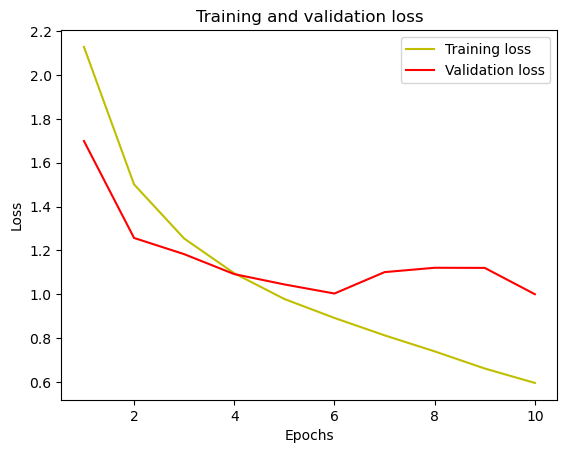

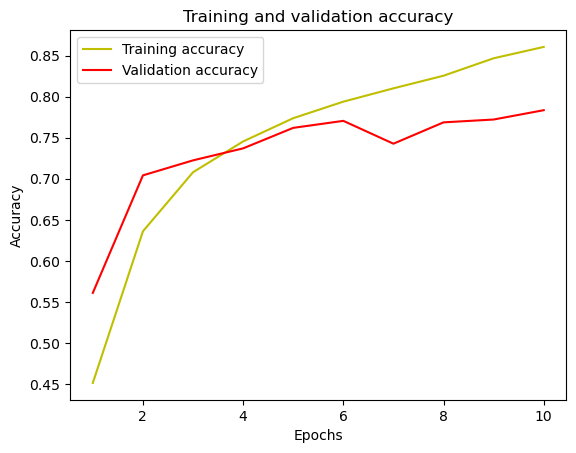

In [80]:
 #Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [82]:
# Generate the test data
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)

# Evaluate the model using the evaluate method
evaluation_results = model.evaluate(test_gen, steps=len(test_idx) // 128)

# Create a dictionary with metric names and their values
results_dict = dict(zip(model.metrics_names, evaluation_results))

print(results_dict)

55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7884 - loss: 0.9947
{'loss': 0.9979304075241089, 'compile_metrics': 0.784375011920929}


In [83]:
import numpy as np

def get_test_data_and_labels(generator, steps):
    all_predictions = []
    all_labels = []
    for _ in range(steps):
        images, labels = next(generator)
        predictions = model.predict(images)
        all_predictions.extend(np.argmax(predictions, axis=1))
        all_labels.extend(np.argmax(labels, axis=1))
    return np.array(all_predictions), np.array(all_labels)

# Generate test data and labels
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
steps = len(test_idx) // 128
predictions, true_labels = get_test_data_and_labels(test_gen, steps)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 

In [84]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predictions)

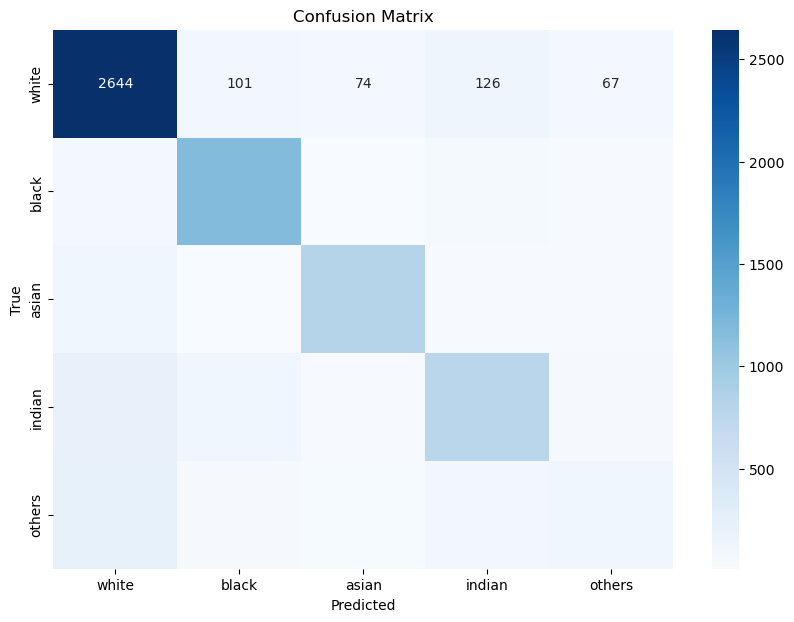

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(RACE_ID_MAP.keys()),
            yticklabels=list(RACE_ID_MAP.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()